# Translating Clinical Findings into Knowledge in Drug Safety Evaluation - Drug Induced Liver Injury Prediction System (DILIps)


This notebook analyzes clinical data for DILI and tries to reproduce Zhichao Liu models.
    
    Index:
            - Data Analysis: Side effects distribution, clustering and correlations.
            
            - Model building: Build models reproducing Liu ones, keeping only those with good quality metrics.
                  FLAME modeling framework is used in this step https://github.com/phi-grib/flame.
              
            - Model validation: Validate models using the same test set.
            
            - Analysis of side-effect importance. Which are the most related to DILI?
            
            - Class type and number of models incriminating DILO --> Comparison to Zhichao Liu models
            
            - Discussion: Some text judging the results.
        
            


## Analysis of the dataset

In [15]:
import pandas as pd
from rdkit.Chem import PandasTools as pt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("dark")
from structure_resolver import * # homemade library to resolve structures from identifiers
                                  # https://github.com/josecarlosgomezt/structure_search
from rdkit.Chem import AllChem
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import matthews_corrcoef as mcc
from sklearn.cross_decomposition import PLSRegression


In [10]:
# Import Flame and RDKit libraries

from flame.build import Build
from flame.predict import Predict
from flame.manage import *
from rdkit.Chem import PandasTools as pt

In [524]:
# Read the data with training set, sheet 0.
tong = pd.read_excel('tong_data.xls', 0)

In [525]:
tong.head()

,DrugbankID,Generic names,PubCID,bilirubinemia,cholecystitis,cholelithiasis,cirrhosis,elevated liver function tests,hepatic failure,hepatic necrosis,hepatitis,hepatomegaly,jaundice,liver disease,liver fatty,liver function tests abnormal,Combined Scores,Distribution_Status
0,DB00333,methadone,4095,0,0,0,0,0,0,0,0,0,0,0,0,0,0,training
1,DB00331,metformin,4091,0,0,0,0,0,0,0,1,0,0,0,0,1,2,training
2,DB00958,carboplatin,38904,0,0,0,0,0,0,0,0,0,0,0,0,1,1,training
3,DB00816,metaproterenol,4086,0,0,0,0,0,0,0,0,0,0,0,0,0,0,training
4,DB00933,mesoridazine,4078,0,0,0,0,0,0,0,0,0,1,0,0,0,1,training


In [526]:
# Distribution of number of side effects per compound.
tong['Combined Scores'].value_counts()

0     424
1     164
2     110
3      71
4      51
5      32
7      15
6      13
8       7
10      1
Name: Combined Scores, dtype: int64

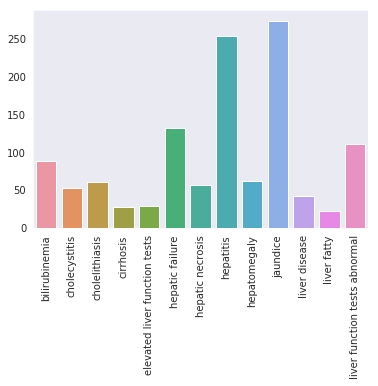

In [527]:
# Plot the distribution of side effects in the data. 
x = []
y = []
for col in tong.columns[3:16]:
    x.append(tong[col].value_counts()[1])
    y.append(col)
ax = sns.barplot(x=y, y=x)
ax = ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

In [528]:
# Get a subframe with only side effect columns
subframe = tong[tong.columns[3:16]]

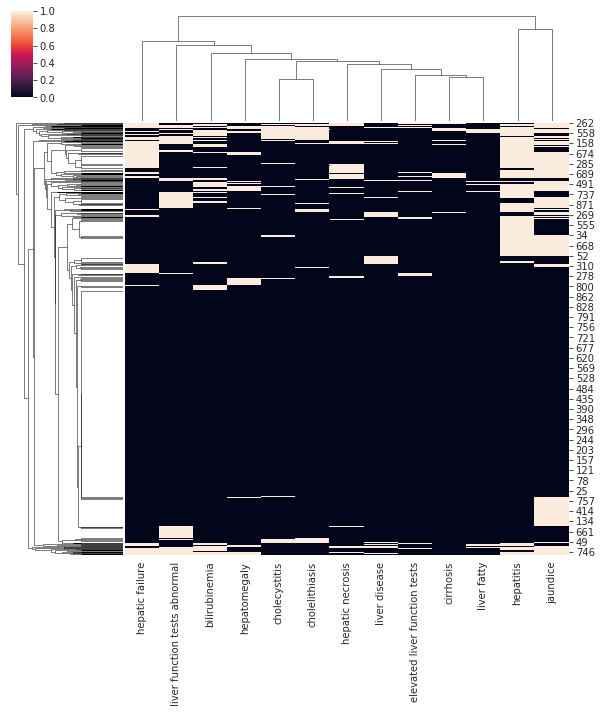

In [529]:
# Plot a clustermap of side effects.
cluster_map = sns.clustermap(subframe)

In [ ]:
# Get the correlation matrix among side effects and plot it in a 
# heatmap
correlation = subframe.corr()
plt.figure(figsize=(12,8))
heatmap = sns.heatmap(correlation)

In [ ]:
# Show correlation matrix
correlation.head()

In [ ]:
## Lets add structures to the dataframe. If this step was already done
## go to the next section and load the sdf file

tong.shape

In [ ]:
# Get InChIs using homemade structure_resolver script
tong = add_inchis(tong, name='Generic names', DBID='DrugbankID')

In [ ]:
# Show entries with not found InChIs
tong[tong['InChI'] == False]

In [ ]:
# Discard InChIs
tong_clean = tong[tong['InChI'] != False]

In [ ]:
# Get MOls from InChIs
mols = []
for inchi in tong_clean['InChI']:
    mols.append(AllChem.MolFromInchi(inchi))
tong_clean['ROMol'] = mols

In [ ]:
# Discard entries with failed mol object retrieval

tong_clean = tong_clean[tong_clean['ROMol'].notnull()]
tong_clean.shape

In [ ]:
# Save the frame into a SDF file

pt.WriteSDF(tong_clean, 'tong_clean.sdf', properties=tong_clean.columns)

## Let's build and evaluate models for each DILI endpoints.

In [ ]:
# Load file (If created previously)

tong_clean = pt.LoadSDF('tong_clean.sdf')

In [ ]:
tong_clean.head()

In [ ]:
# Function to set parameters and build the model
def build_model(end):
    # Instantiate flame Build class
    build = Build(end)
    # Set model parameters
    build.param.setVal('conformal', True)
    build.param.setVal('verbose_error', False)
    build.param.setVal('tune', True)
    build.param.setVal('ModelValidationCV', 'loo')
    build.param.setVal('ModelValidationN', 10)
    build.param.setVal('computeMD_method', ['RDKit_md'])
    build.param.setVal('quantitative', False)
    build.param.setVal('modelAutoscaling', True)
    build.param.setVal('model', 'RF')
    build.param.setVal('imbalance', 'simple_subsampling')
    build.param.setVal('SDFile_activity', end)
    build.param.update_file(end,)
    build.run(f'sdfs/{end}.sdf')

In [ ]:
# Create endpoint separate files to create Flame models.
endpoints = tong_clean.columns[8:]
for end in endpoints:
    print(end)
    sdf = tong_clean[tong_clean[end].notnull()]
    pt.WriteSDF(sdf, f'./sdfs/{end}.sdf', properties=sdf.columns)

In [ ]:
# Build models for each endpoint and add reliable models
# to a list (reliable are models with MCC>0.3)

DILI_reliable = []  # List with good built DILI models
for end in endpoints[:]:
    # Create a new endpoint
    action_new(end)
    # action_remove(end, 1)  # Remove version, if rebuilding model
    os.system('rm ./sdfs/data.pkl') # Remove data created for other model
    build_model(end)
    results = np.asarray(json.loads(action_results(end, 0)[1])['model_valid_info'], dtype=object)
    # Get cross-validation MCC
    mcc = np.where(results[:, 0] == 'MCC') #  Returns the 2D indexex to whre MCC is located
    mcc = results[mcc[0]][0][2]  # Get the row where MCC is, and then get the actual value.
    if mcc >= 0.3:  # keep only models with MCC higher than 0.3
        DILI_reliable.append(end)
        action_publish(end)  # Publish the model 
    else:
        action_kill(end)


In [ ]:
 #  Get validation statistics from built models
lista = []
columns = ['Endpoint']
for index, end in enumerate(DILI_reliable):

    results = json.loads(action_results(end, 1)[1])['model_valid_info']
    if index == 0:
        for el in results:
            columns.append(el[0])
    values = [end]
    for el in results:
        values.append(el[-1])
    print(columns)
    print(values)
    lista.append(values)
frame = pd.DataFrame(lista, columns=columns)
    
    
    

In [ ]:
# Show models sorted by their MCC
frame.sort_values(by=['MCC'], ascending=[False])

In [ ]:
frame.to_csv("models_DILI_mechinistic.csv")

## Load validation set (LTKB)

In [7]:
# Get prediction of a set of compounds for a given list of models. Endpoint and version column names
# needed. Returns a dataframe with predictions for each endpoint as columns
def get_predictions(models_frame, file, name_col, version_col):
    model_predictions = pd.DataFrame()
    for model, version in zip(models_frame[name_col], models_frame[version_col]):
        pred =  Predict(model, version)
        results = pred.run(file)
        results = json.loads(results[1])
        c0 = np.asarray(results['c0'])
        c1 = np.asarray(results['c1'])
        final = []
        for val, val2 in zip(c0, c1):
            if val and not val2:
                final.append(0)
            elif val2 and not val:
                final.append(1)
            else:
                final.append(2)
        model_predictions[model + '-' + str(version)] = final
    return model_predictions

In [8]:
# Get consensus prediction. Here the rules to class assignment. 
def get_consensus(frame):
    consensus = []
    for index, row in frame.iterrows():
        val = 0
        # Get number of positive, negative and out of AD
        # predictions
        counts = row.value_counts().to_dict()
        if 1 in counts.keys():
            val = 1
            try:
                if counts[0] > counts[1]:
                    val = 0
            except:
                pass
        else:
            if 0 in counts.keys():
                val = 0
            else:
                val = 2

        consensus.append(val)
    return consensus
            

In [155]:
# Read validation set used by Zhichao Liu et Al. (subset of LTKB dataset)
ltkb = pd.read_excel('tong_data.xls', 1)

In [156]:
ltkb.head()

,DrugBank ID,Drug Name,DILI Label Sections,CAS No.,PubCID,DILI Endpoints,Distribution_Status,#models incriminating a drug as DILI positive in DILIps,DILI positive/negative as observed
0,DB00437,allopurinol,Warnings and Precautions,315-30-0,2094,Less-DILI-concern,(Not used) training,0,ambiguous call
1,DB00915,amantadine,Warnings and Precautions,768-94-5,2130,Less-DILI-concern,(Not used) training,0,ambiguous call
2,DB01060,amoxicillin,Warnings and Precautions,26787-78-0,33613,Less-DILI-concern,(Not used) training,1,ambiguous call
3,DB00993,azathioprine,Warnings and Precautions,446-86-6,2265,Less-DILI-concern,(Not used) training,0,ambiguous call
4,DB00958,carboplatin,Warnings and Precautions,41575-94-4,498142,Less-DILI-concern,(Not used) training,0,ambiguous call


In [157]:
ltkb.shape

(286, 9)

In [181]:
# Get validation entries from Tong and discard Less-DILI-concern entries

ltkb_validation = ltkb[ltkb['Distribution_Status'].str.contains('validation')]
ltkb_validation = ltkb_validation[ltkb_validation['DILI Endpoints'] != 'Less-DILI-concern']
ltkb_validation.shape

(73, 9)

In [182]:
# Add InChIs to the dataframe and discard entries with no InChI
ltkb_val = add_inchis(ltkb_validation, name='Drug Name', CASRN='CAS No.', DBID='DrugBank ID')
ltkb_val = ltkb_val[ltkb_val['InChI'] != False]
ltkb_val.shape

100%|██████████| 73/73 [00:24<00:00,  4.06it/s]


(71, 10)

In [183]:
# Get MOls from InChIs
mols = []
for inchi in ltkb_val['InChI']:
    mols.append(AllChem.MolFromInchi(inchi))
ltkb_val['ROMol'] = mols

In [184]:
# Check if there is training/test sets overlap
drugbdb = tong['PubCID'].tolist()
ltkb_validation[ltkb_validation['PubCID'].isin(drugbdb)]

NameError: name 'tong' is not defined

In [185]:
# Save test set to a SDF file
pt.WriteSDF(ltkb_val, 'ltkb_val.sdf', properties=ltkb_validation.columns)

In [197]:
# Load test set to a dataframe
ltkb_val = pt.LoadSDF('ltkb_val.sdf')

In [198]:
ltkb_validation.head()
ltkb_val.shape

(71, 12)

In [199]:
### Compute predictions

In [204]:
# Read info on created models
model_list = pd.read_csv('models_DILI_mechinistic.csv')
model_list.head()

,Unnamed: 0,Endpoint,TP,TN,FP,FN,Sensitivity,Specificity,MCC,Conformal_coverage,Conformal_accuracy
0,0,bilirubinemia,36,43,19,10,0.782609,0.693548,0.470984,0.613636,0.731481
1,1,cirrhosis,8,7,2,6,0.571429,0.777778,0.343792,0.425926,0.652174
2,2,hepatic failure,50,38,25,16,0.757576,0.603175,0.365529,0.488636,0.682171
3,3,hepatitis,114,101,47,42,0.730769,0.682432,0.413785,0.598425,0.707237
4,4,jaundice,134,104,54,48,0.736264,0.658228,0.395732,0.622711,0.700000


In [218]:
# Add mdeo version to the FRAME
model_list['version'] = 2

In [219]:
# Get prediction of a set of compounds for a given list of models. Endpoint and version column names
# needed. Returns a dataframe with predictions for each endpoint as columns
pred_ltkb = get_predictions(model_list, 'ltkb_val.sdf', 'Endpoint', 'version')

INFO - Running with input type: molecule
WARNING - Unable to log syserror, this probably means flame is called from an ipython interactive terminal. Otherwise, please notify the developers
INFO - Starting normalization...
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #27 mol0000000027. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #41 mol0000000041. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #43 mol0000000043. Skipping normalization
ERROR - Critical standardize exception: Time taken shows problem with moleule when processing mol #67 mol0000000067. Skipping normalization
INFO - Computing molecular descriptors with methods ['RDKit_md']...
INFO - Computing RDKit descriptors...
INFO - Running with input type: molecule
WARNING - Unable to log syserror, this probably means flame is called from

       obj_num ( number of objects ) : 71.0


ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #27 mol0000000027. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #41 mol0000000041. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #43 mol0000000043. Skipping normalization
ERROR - Critical standardize exception: Time taken shows problem with moleule when processing mol #67 mol0000000067. Skipping normalization
INFO - Computing molecular descriptors with methods ['RDKit_md']...
INFO - Computing RDKit descriptors...
INFO - Running with input type: molecule


       obj_num ( number of objects ) : 71.0


WARNING - Unable to log syserror, this probably means flame is called from an ipython interactive terminal. Otherwise, please notify the developers
INFO - Starting normalization...
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #27 mol0000000027. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #41 mol0000000041. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #43 mol0000000043. Skipping normalization
ERROR - Critical standardize exception: Time taken shows problem with moleule when processing mol #67 mol0000000067. Skipping normalization
INFO - Computing molecular descriptors with methods ['RDKit_md']...
INFO - Computing RDKit descriptors...
INFO - Running with input type: molecule
WARNING - Unable to log syserror, this probably means flame is called from an ipython interactive terminal. Otherwi

       obj_num ( number of objects ) : 71.0


ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #27 mol0000000027. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #41 mol0000000041. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #43 mol0000000043. Skipping normalization
ERROR - Critical standardize exception: Time taken shows problem with moleule when processing mol #67 mol0000000067. Skipping normalization
INFO - Computing molecular descriptors with methods ['RDKit_md']...
INFO - Computing RDKit descriptors...
INFO - Running with input type: molecule
WARNING - Unable to log syserror, this probably means flame is called from an ipython interactive terminal. Otherwise, please notify the developers
INFO - Starting normalization...


       obj_num ( number of objects ) : 71.0


ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #27 mol0000000027. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #41 mol0000000041. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #43 mol0000000043. Skipping normalization
ERROR - Critical standardize exception: Time taken shows problem with moleule when processing mol #67 mol0000000067. Skipping normalization
INFO - Computing molecular descriptors with methods ['RDKit_md']...
INFO - Computing RDKit descriptors...


       obj_num ( number of objects ) : 71.0


In [220]:
# Plot frame with different endpoint predictions
pred_ltkb.head(5)

,bilirubinemia-2,cirrhosis-2,hepatic failure-2,hepatitis-2,jaundice-2
0,1,2,1,2,1
1,0,1,2,2,2
2,1,2,0,2,2
3,0,2,1,2,2
4,2,1,1,1,1


In [221]:
pred_ltkb.shape

(71, 5)

In [222]:
ltkb_consensus = get_consensus(pred_ltkb)

In [344]:
# Create a new dataframe with consensus predictions and experimental values
ltkb_results = pd.DataFrame()
ltkb_results['ltkb'] = ltkb_val['DILI positive/negative as observed'].astype(np.int)
ltkb_results['pred'] = ltkb_consensus
print('Total number of predictions: ', len(ltkb_results))
# Discard compounds out of the AD
ad_in = ltkb_results[ltkb_results['pred'] != 2]
print('Number of preditions in the applicability domain: ', len(ad_in))

Total number of predictions:  71
Number of preditions in the applicability domain:  70


In [232]:
matthew = mcc(ad_in['pred'].tolist(), ad_in['ltkb'].tolist(), )
TN, FP, FN, TP = cm(ad_in['pred'].tolist(), ad_in['ltkb'].tolist()).ravel()
sensitivity = (TP / (TP + FP))
specificity = (TN / (TN + FN))
print('MCC: ', matthew)
print('Sens: ', sensitivity)
print('Spec: ', specificity)

MCC:  0.4376940563413236
MCC:  0.4376940563413236
Sens:  0.734375
Spec:  1.0


## Load validation set 2 (PfizerDataset)

In [233]:
import pandas as pd
from structure_resolver import * # homemade library to resolve structures from identifiers


In [234]:
# Read validation set used by Zhichao Liu et Al. (pfizer dataset)
pfizer = pd.read_excel('tong_data.xls', 2)

In [235]:
pfizer.head()

,Drugbank ID,Name,CAS No.,PubCID,Bin_Details,Distrubition_Status,#models incriminating a drug as DILI positive in DILIps,DILI positive/negative as observed
0,DB00339,Pyrazinamide,98-96-4,1046,HH,Training,0,1
1,DB00908,quinidine,56-54-2,1065,HH,Training,3,1
2,DB00252,phenytoin,57-41-0,1775,HH,Training,1,1
3,DB00819,Acetazolamide,59-66-5,1986,HH,Training,2,1
4,DB00970,Dactinomycin,50-76-0,2019,HH,Training,1,1


In [236]:
pfizer.columns

Index(['Drugbank ID', 'Name', 'CAS No.', 'PubCID', 'Bin_Details', 'Distrubition_Status', '#models incriminating a drug as DILI positive in DILIps', 'DILI positive/negative as observed'], dtype='object')

In [237]:
# Get validation compounds
pfizer = pfizer[pfizer['Distrubition_Status'].str.contains('Val')]
print(len(pfizer))
pfizer.shape

148


(148, 8)

In [238]:
# Add InChIs to the dataframe and discard entries with no InChI
pfizer_inchis = add_inchis(pfizer, name='Name', CASRN='CAS No.', DBID='Drugbank ID')
pfizer_inchis = pfizer_inchis[pfizer_inchis['InChI'] != False]
pfizer_inchis.shape

100%|██████████| 148/148 [00:34<00:00,  3.74it/s]


(148, 9)

In [58]:
# Get MOls from InChIs
mols = []
for inchi in pfizer_inchis['InChI']:
    mols.append(AllChem.MolFromInchi(inchi))
pfizer_inchis['ROMol'] = mols

In [59]:
# Save test set to a SDF file
pt.WriteSDF(pfizer_inchis, 'pfizer_val.sdf', properties=pfizer_inchis.columns)

In [254]:
# Load  test set to a frame

pfizer_val = pt.LoadSDF('pfizer_val.sdf')

In [255]:
# Read info on created models
model_list = pd.read_csv('models_DILI_mechinistic.csv')
model_list['version'] = 2
model_list.head()

,Unnamed: 0,Endpoint,TP,TN,FP,FN,Sensitivity,Specificity,MCC,Conformal_coverage,Conformal_accuracy,version
0,0,bilirubinemia,36,43,19,10,0.782609,0.693548,0.470984,0.613636,0.731481,2
1,1,cirrhosis,8,7,2,6,0.571429,0.777778,0.343792,0.425926,0.652174,2
2,2,hepatic failure,50,38,25,16,0.757576,0.603175,0.365529,0.488636,0.682171,2
3,3,hepatitis,114,101,47,42,0.730769,0.682432,0.413785,0.598425,0.707237,2
4,4,jaundice,134,104,54,48,0.736264,0.658228,0.395732,0.622711,0.700000,2


In [243]:
# Get prediction of a set of compounds for a given list of models. Endpoint and version column names
# needed. Returns a dataframe with predictions for each endpoint as columns
pred_pfizer = get_predictions(model_list, 'pfizer_val.sdf', 'Endpoint', 'version')

INFO - Running with input type: molecule
WARNING - Unable to log syserror, this probably means flame is called from an ipython interactive terminal. Otherwise, please notify the developers
INFO - Starting normalization...
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #55 mol0000000055. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #71 mol0000000071. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #76 mol0000000076. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #78 mol0000000078. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #116 mol0000000116. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when 

       obj_num ( number of objects ) : 148.0


INFO - Starting normalization...
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #55 mol0000000055. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #71 mol0000000071. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #76 mol0000000076. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #78 mol0000000078. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #116 mol0000000116. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #128 mol0000000128. Skipping normalization
INFO - Computing molecular descriptors with methods ['RDKit_md']...
INFO - Computing RDKit descriptors...
INFO - Running with input

       obj_num ( number of objects ) : 148.0


INFO - Starting normalization...
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #55 mol0000000055. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #71 mol0000000071. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #76 mol0000000076. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #78 mol0000000078. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #116 mol0000000116. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #128 mol0000000128. Skipping normalization
INFO - Computing molecular descriptors with methods ['RDKit_md']...
INFO - Computing RDKit descriptors...
INFO - Running with input

       obj_num ( number of objects ) : 148.0


INFO - Starting normalization...
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #55 mol0000000055. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #71 mol0000000071. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #76 mol0000000076. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #78 mol0000000078. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #116 mol0000000116. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #128 mol0000000128. Skipping normalization
INFO - Computing molecular descriptors with methods ['RDKit_md']...
INFO - Computing RDKit descriptors...
INFO - Running with input

       obj_num ( number of objects ) : 148.0


INFO - Starting normalization...
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #55 mol0000000055. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #71 mol0000000071. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #76 mol0000000076. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #78 mol0000000078. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #116 mol0000000116. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #128 mol0000000128. Skipping normalization
INFO - Computing molecular descriptors with methods ['RDKit_md']...
INFO - Computing RDKit descriptors...


       obj_num ( number of objects ) : 148.0


In [256]:
pfizer_consensus = get_consensus(pred_pfizer)

In [258]:
len(pfizer_consensus)

148

In [ ]:
len(pfizer_consensus)

In [261]:
# Create a new dataframe with consensus predictions and experimental values
results_pfizer = pd.DataFrame()
results_pfizer['pfizer'] = pfizer_val['DILI positive/negative as observed'].astype(np.int)
results_pfizer['pred'] = pfizer_consensus
print(len(results_pfizer))
# Discard compounds out of the AD
ad_in = results_pfizer[results_pfizer['pred'] != 2]
print(len(ad_in))

148
138


In [262]:
matthew = mcc(ad_in['pred'].tolist(), ad_in['pfizer'].tolist(), )
TN, FP, FN, TP = cm(ad_in['pred'].tolist(), ad_in['pfizer'].tolist()).ravel()
sensitivity = (TP / (TP + FP))
specificity = (TN / (TN + FN))
print('MCC: ', matthew)
print('Sens: ', sensitivity)
print('Spec: ', specificity)

MCC:  0.12265844699580944
Sens:  0.5411764705882353
Spec:  0.5849056603773585


## Load validation set 3 (Obrien)

In [263]:
import pandas as pd
from structure_resolver import * # homemade library to resolve structures from identifiers


In [264]:
# Read validation set used by Zhichao Liu et Al. (pfizer dataset)
obrien = pd.read_excel('tong_data.xls', 3)

In [265]:
obrien.head()

,DrugbankID,Obrien's paper Name,Cas No.,PubCID,Distribution_Status,DILI Endpoints,#models incriminating a drug as DILI positive in DILIps,DILI positive/negative as observed
0,Severelyhepatotoxicdrugs,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,DB00316,Acetaminophen,103-90-2,1983.0,Validation,Positive,0.0,1.0
2,DB00233,Aminosalycilate,65-49-6,4649.0,Validation,Positive,1.0,1.0
3,DB00321,Amitryptilline,50-48-6,2160.0,Training,Positive,2.0,1.0
4,DB01118,Amiodarone,1951-25-3,2157.0,Training,Positive,6.0,1.0


In [266]:
# Get validation compounds
obrien = obrien[obrien['Distribution_Status'] == 'Validation']
print(len(obrien))
obrien.shape

40


(40, 8)

In [267]:
# Add InChIs to the dataframe and discard entries with no InChI
obrien_inchis = add_inchis(obrien, name="Obrien's paper Name", CASRN='Cas No.', DBID='DrugbankID')
obrien_inchis = obrien_inchis[obrien_inchis['InChI'] != False]
obrien_inchis.shape

100%|██████████| 40/40 [00:11<00:00,  3.80it/s]


(40, 9)

In [299]:
# Get MOls from InChIs
mols = []
for inchi in obrien_inchis['InChI']:
    mols.append(AllChem.MolFromInchi(inchi))
obrien_inchis['ROMol'] = mols

In [300]:
# Save test set to a SDF file
pt.WriteSDF(obrien_inchis, 'obrien_val.sdf', properties=obrien_inchis.columns)

In [301]:
# Load test set to a dataframe
obrien_val = pt.LoadSDF('obrien_val.sdf')

In [302]:
# Read info on created models
model_list = pd.read_csv('models_DILI_mechinistic.csv')
model_list['version'] = 2
model_list.head()

,Unnamed: 0,Endpoint,TP,TN,FP,FN,Sensitivity,Specificity,MCC,Conformal_coverage,Conformal_accuracy,version
0,0,bilirubinemia,36,43,19,10,0.782609,0.693548,0.470984,0.613636,0.731481,2
1,1,cirrhosis,8,7,2,6,0.571429,0.777778,0.343792,0.425926,0.652174,2
2,2,hepatic failure,50,38,25,16,0.757576,0.603175,0.365529,0.488636,0.682171,2
3,3,hepatitis,114,101,47,42,0.730769,0.682432,0.413785,0.598425,0.707237,2
4,4,jaundice,134,104,54,48,0.736264,0.658228,0.395732,0.622711,0.700000,2


In [ ]:
# Get prediction of a set of compounds for a given list of models. Endpoint and version column names
# needed. Returns a dataframe with predictions for each endpoint as columns
pred_obrien = get_predictions(model_list, 'obrien_val.sdf', 'Endpoint', 'version')

In [309]:
obrien_consensus = get_consensus(pred_obrien)

In [311]:
# Create a new dataframe with consensus predictions and experimental values
obrien_results = pd.DataFrame()
obrien_results['obrien'] = pd.to_numeric(obrien_val['DILI positive/negative as observed'])
obrien_results['pred'] = obrien_consensus
print(len(obrien_results))
# Discard compounds out of the AD
ad_in = obrien_results[obrien_results['pred'] != 2]
print(len(ad_in))

40
37


In [312]:
matthew = mcc(ad_in['pred'].tolist(), ad_in['obrien'].tolist(), )
TN, FP, FN, TP = cm(ad_in['pred'].tolist(), ad_in['obrien'].tolist()).ravel()
sensitivity = (TP / (TP + FP))
specificity = (TN / (TN + FN))
print('MCC: ', matthew)
print('Sens: ', sensitivity)
print('Spec: ', specificity)

MCC:  0.28711521724254246
Sens:  0.6521739130434783
Spec:  0.6428571428571429


## Now lets analyze variable importance using PLS



In [18]:
'''Loadings plot. Addapted from PCA plotting code snippet found in StackOverflow'''
def create_loadings_plot(score, coeff, coeff_y, labels, color=None, source=None):
    plt.figure(figsize=(12,10))
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()

    #Call the function. Use only the 2 PCs.


    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    fig = sns.scatterplot(xs * scalex,ys * scaley, hue=source )
    fig = plt.scatter([coeff_y[0]], [coeff_y[1]], c='black', s=20)
    plt.text(coeff_y[0] * 1.15, coeff_y[1] * 1.15, "Y-loadings",
                     color='red', ha='center', va='center')

    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1),
                     color='g', ha='center', va='center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i],
                     color='g', ha='center', va ='center')
    return 


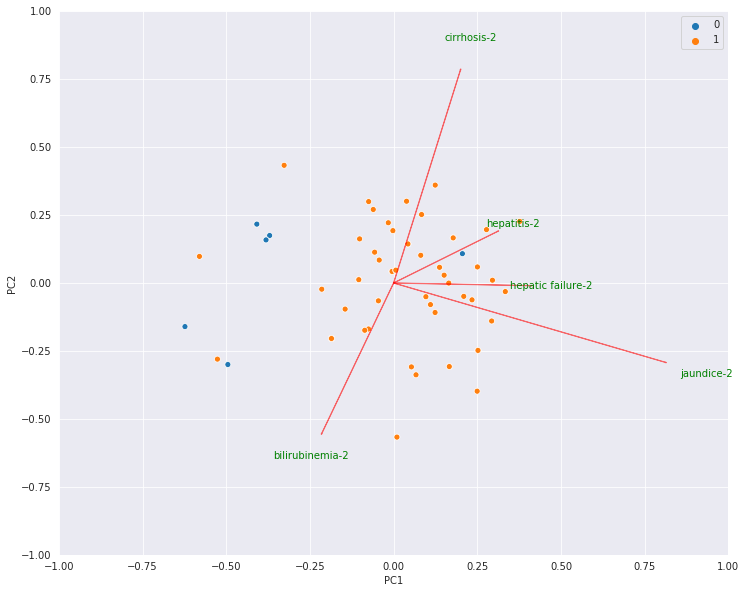

In [361]:
# LTKB loadings plot
X = pred_ltkb.values
Y = ltkb_results['ltkb'].values
pls = PLSRegression(n_components=2)
projection = pls.fit_transform(X=X,y=Y)
score = projection[0][:, 0:2]
coeff = pls.x_loadings_
labels = pred_ltkb.columns
create_loadings_plot(score, coeff, labels)
ltkb_pls_coef = pls.coef_

In [360]:
labels

Index(['bilirubinemia-2', 'cirrhosis-2', 'hepatic failure-2', 'hepatitis-2', 'jaundice-2'], dtype='object')

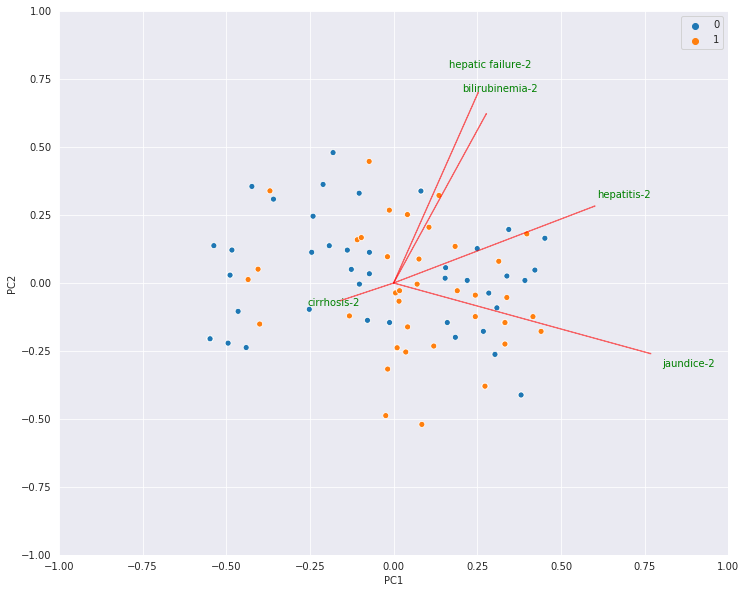

In [362]:
X = pred_pfizer.values
Y = results_pfizer['pfizer'].values
pls = PLSRegression(n_components=2)
projection = pls.fit_transform(X=X,y=Y)
score = projection[0][:, 0:2]
coeff = pls.x_loadings_
labels = pred_pfizer.columns
create_loadings_plot(score, coeff, labels)
pfizer_pls_coef = pls.coef_

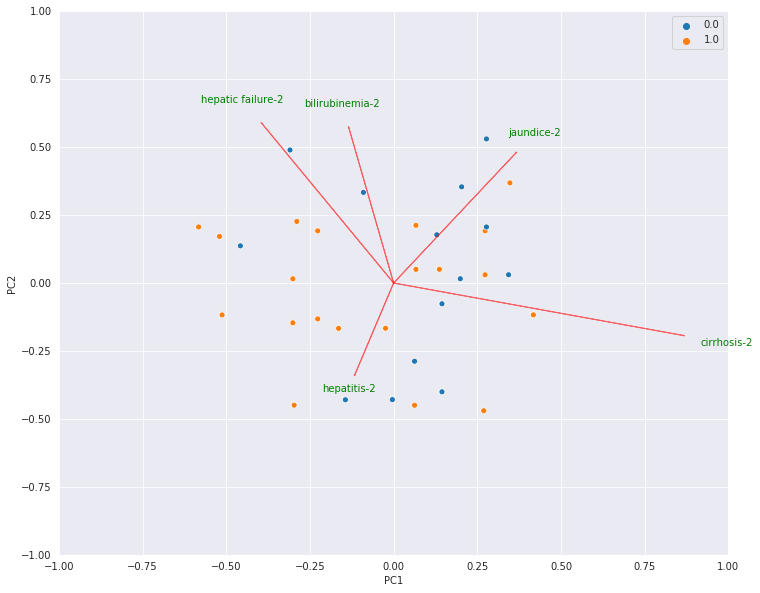

In [364]:
X = pred_obrien.values
Y = obrien_results['obrien'].values
pls = PLSRegression(n_components=2)
projection = pls.fit_transform(X=X,y=Y)
score = projection[0][:, 0:2]
coeff = pls.x_loadings_
labels = pred_obrien.columns
create_loadings_plot(score, coeff, labels)
obrien_pls_coef = pls.coef_

In [367]:
ltkb_pls_coef.T[0]

array([-0.01341421,  0.00355047,  0.04513737,  0.03130363,  0.10705115])

In [368]:
pfizer_pls_coef.T[0]

array([-0.01187175, -0.01631819, -0.0281083 ,  0.03265722,  0.09865909])

## Discussion

Available hepatotoxic data from SIDER extracted by Zhichao Liu et all was used in order to reproduce DILI prediction models.
Distribution among side effects show 2 main properties. Data is unbalanced and different endpoints are not quite correlated.

Model building shows that, in contrast with the resulst obtainded by Zhichao Liu, not very good performance at crossvalidation, with
only 5 models with reasonable qualitity (when Zhichao Liu ones were almost perfect). In this case Kfold=5. Even trying to reproduce Zhichao Liu models
using the same algorithm (Gaussian Naive Bayes) and descriptors (circular FCFP) results in very poor performance. 
However, external validation using the same data shows that models built here outperform Zhichao Liu ones.

Also, variable importance analysis using PLS points out hepatic-failure and jaundice as the most informative varibles to classify a compound 
as hepatotoxic or not.

In [370]:
obrien_pls_coef.T

array([[-0.0119578 , -0.07137941,  0.00801612,  0.03402429, -0.04894926]])

In [373]:
coeffs = []
coeffs.append(['ltkb'] + ltkb_pls_coef.T[0].tolist())
coeffs.append(['pfizer'] + pfizer_pls_coef.T[0].tolist())
coeffs.append(['obrien'] + obrien_pls_coef.T[0].tolist())

In [378]:
frame_coeffs = pd.DataFrame(coeffs, columns=(['dataset'] + pred_ltkb.columns.tolist()))

In [377]:
pred_ltkb.columns

Index(['bilirubinemia-2', 'cirrhosis-2', 'hepatic failure-2', 'hepatitis-2', 'jaundice-2'], dtype='object')

In [379]:
frame_coeffs

,dataset,bilirubinemia-2,cirrhosis-2,hepatic failure-2,hepatitis-2,jaundice-2
0,ltkb,-0.013414,0.003550,0.045137,0.031304,0.107051
1,pfizer,-0.011872,-0.016318,-0.028108,0.032657,0.098659
2,obrien,-0.011958,-0.071379,0.008016,0.034024,-0.048949


## Relationship between number of incriminating models and severity

In [427]:
# Read validation set used by Zhichao Liu et Al. (subset of LTKB dataset)
val_all = pd.read_excel('validation_all.xls', 1)

In [428]:
val_source = pd.read_excel('validation_all.xls', 0)

In [444]:
val_source = val_source[['PubCID', 'Sources']].drop_duplicates(subset='PubCID')

In [445]:
val_source.shape

(216, 2)

In [383]:
val_all.head()

,Commonality,DrugBank ID,Drug Name,PubCID,#models incriminating a drug as DILI positive in DILIps,DILI positive/negative as observed,DILI label section
0,unique,DB01388,Mibefradil,60663,5,0,NaN
1,unique,NaN,alatrofloxacin,3086677,5,1,Withdrawn
2,unique,NaN,benzarone,255968,5,1,Withdrawn
3,unique,DB01283,lumiracoxib,151166,5,1,Withdrawn
4,unique,NaN,clometacin,33176,4,1,Withdrawn


In [430]:
val_all.shape

(208, 7)

In [431]:
# Add InChIs to the dataframe and discard entries with no InChI
val_all_inchis = add_inchis(val_all, name="Drug Name", CASRN=None, DBID='DrugBank ID')
val_all_inchis = val_all_inchis[val_all_inchis['InChI'] != False]
val_all_inchis.shape

100%|██████████| 208/208 [00:57<00:00,  4.26it/s]


(186, 8)

In [436]:
# Get MOls from InChIs
mols = []
for inchi in val_all_inchis['InChI']:
    mols.append(AllChem.MolFromInchi(inchi))
val_all_inchis['ROMol'] = mols

In [437]:
val_all_inchis.shape

(186, 9)

In [446]:
val_all_merged = val_all_inchis.merge(val_source, how='left', on='PubCID').reset_index(drop=True)

In [447]:
val_all_merged.shape

(186, 10)

In [450]:
# Save test set to a SDF file
pt.WriteSDF(val_all_merged, 'val_all.sdf', properties=val_all_merged.columns)

In [4]:
# Load test set to a dataframe
val_all = pt.LoadSDF('val_all.sdf')

In [5]:
# Read info on created models
model_list = pd.read_csv('models_DILI_mechinistic.csv')
model_list['version'] = 2
model_list.head()

,Unnamed: 0,Endpoint,TP,TN,FP,FN,Sensitivity,Specificity,MCC,Conformal_coverage,Conformal_accuracy,version
0,0,bilirubinemia,36,43,19,10,0.782609,0.693548,0.470984,0.613636,0.731481,2
1,1,cirrhosis,8,7,2,6,0.571429,0.777778,0.343792,0.425926,0.652174,2
2,2,hepatic failure,50,38,25,16,0.757576,0.603175,0.365529,0.488636,0.682171,2
3,3,hepatitis,114,101,47,42,0.730769,0.682432,0.413785,0.598425,0.707237,2
4,4,jaundice,134,104,54,48,0.736264,0.658228,0.395732,0.622711,0.700000,2


In [11]:
pred_all = get_predictions(model_list, 'val_all.sdf', 'Endpoint', 'version')
consensus_all = get_consensus(pred_all)

INFO - Running with input type: molecule
WARNING - Unable to log syserror, this probably means flame is called from an ipython interactive terminal. Otherwise, please notify the developers
INFO - Starting normalization...
ERROR - Critical standardize exception: Time taken shows problem with moleule when processing mol #47 mol0000000047. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #88 mol0000000088. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #119 mol0000000119. Skipping normalization
INFO - Computing molecular descriptors with methods ['RDKit_md']...
INFO - Computing RDKit descriptors...
INFO - Running with input type: molecule
WARNING - Unable to log syserror, this probably means flame is called from an ipython interactive terminal. Otherwise, please notify the developers


       obj_num ( number of objects ) : 186.0


INFO - Starting normalization...
ERROR - Critical standardize exception: Time taken shows problem with moleule when processing mol #47 mol0000000047. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #88 mol0000000088. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #119 mol0000000119. Skipping normalization
INFO - Computing molecular descriptors with methods ['RDKit_md']...
INFO - Computing RDKit descriptors...
INFO - Running with input type: molecule
WARNING - Unable to log syserror, this probably means flame is called from an ipython interactive terminal. Otherwise, please notify the developers


       obj_num ( number of objects ) : 186.0


INFO - Starting normalization...
ERROR - Critical standardize exception: Time taken shows problem with moleule when processing mol #47 mol0000000047. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #88 mol0000000088. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #119 mol0000000119. Skipping normalization
INFO - Computing molecular descriptors with methods ['RDKit_md']...
INFO - Computing RDKit descriptors...
INFO - Running with input type: molecule
WARNING - Unable to log syserror, this probably means flame is called from an ipython interactive terminal. Otherwise, please notify the developers


       obj_num ( number of objects ) : 186.0


INFO - Starting normalization...
ERROR - Critical standardize exception: Time taken shows problem with moleule when processing mol #47 mol0000000047. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #88 mol0000000088. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #119 mol0000000119. Skipping normalization
INFO - Computing molecular descriptors with methods ['RDKit_md']...
INFO - Computing RDKit descriptors...
INFO - Running with input type: molecule
WARNING - Unable to log syserror, this probably means flame is called from an ipython interactive terminal. Otherwise, please notify the developers


       obj_num ( number of objects ) : 186.0


INFO - Starting normalization...
ERROR - Critical standardize exception: Time taken shows problem with moleule when processing mol #47 mol0000000047. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #88 mol0000000088. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #119 mol0000000119. Skipping normalization
INFO - Computing molecular descriptors with methods ['RDKit_md']...
INFO - Computing RDKit descriptors...


       obj_num ( number of objects ) : 186.0


In [12]:
# Create a new dataframe with consensus predictions and experimental values
all_results = pd.DataFrame()
all_results['all'] = pd.to_numeric(val_all['DILI positive/negative as observed'])
all_results['pred'] = consensus_all
print(len(all_results))
# Discard compounds out of the AD
ad_in = all_results[all_results['pred'] != 2]
print(len(ad_in))

186
176


In [13]:
matthew = mcc(ad_in['pred'].tolist(), ad_in['all'].tolist(), )
TN, FP, FN, TP = cm(ad_in['pred'].tolist(), ad_in['all'].tolist()).ravel()
sensitivity = (TP / (TP + FP))
specificity = (TN / (TN + FN))
print('MCC: ', matthew)
print('Sens: ', sensitivity)
print('Spec: ', specificity)

MCC:  0.17668494017065453
Sens:  0.5983606557377049
Spec:  0.5925925925925926


Index(['bilirubinemia-2', 'cirrhosis-2', 'hepatic failure-2', 'hepatitis-2', 'jaundice-2'], dtype='object')


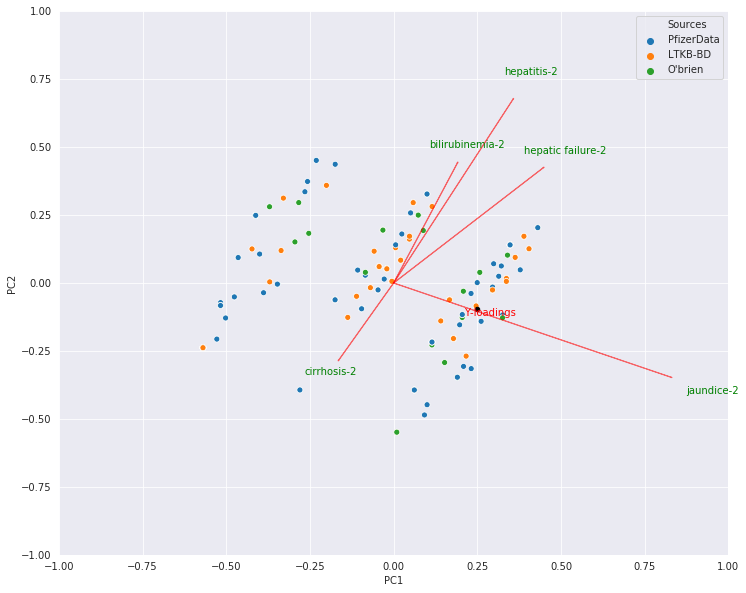

In [21]:
X = pred_all.values
Y = all_results['all'].values
pls = PLSRegression(n_components=2)
projection = pls.fit_transform(X=X,y=Y)
score = projection[0][:, 0:2]
coeff = pls.x_loadings_
coeff_y = pls.y_loadings_[0]
print(pred_all.columns)
labels = pred_all.columns
source = val_all['Sources']
create_loadings_plot(score, coeff, coeff_y, labels, color=Y, source=source)
all_pls_coef = pls.coef_

In [521]:
pls.coef_

array([[-0.00384815],
       [-0.00921687],
       [ 0.0173578 ],
       [-0.00868623],
       [ 0.13295347]])

In [522]:
pls.x_loadings_

array([[ 0.19054695,  0.44159223],
       [-0.16379076, -0.28330068],
       [ 0.44654853,  0.42364732],
       [ 0.35661601,  0.67600546],
       [ 0.82787024, -0.34641014]])

In [23]:
pred_label = pred_all.copy()

In [24]:
pred_label['label_section'] = val_all['DILI label section']

In [25]:
pred_label.head(1)

,bilirubinemia-2,cirrhosis-2,hepatic failure-2,hepatitis-2,jaundice-2,label_section
0,1,1,2,2,2,nan


In [538]:
pred_label['bilirubinemia-2'].value_counts()

2    82
0    65
1    39
Name: bilirubinemia-2, dtype: int64

In [539]:
pred_label['jaundice-2'].value_counts()

2    83
1    59
0    44
Name: jaundice-2, dtype: int64

In [540]:
pred_label['cirrhosis-2'].value_counts()

2    109
1     48
0     29
Name: cirrhosis-2, dtype: int64

In [541]:
pred_label['hepatic failure-2'].value_counts()

2    79
0    59
1    48
Name: hepatic failure-2, dtype: int64

In [542]:
pred_label['hepatitis-2'].value_counts()

2    92
1    53
0    41
Name: hepatitis-2, dtype: int64

In [33]:
suma = []
for index, row in pred_label[pred_label.columns[:-1]].iterrows():
    try:
        entry = row.value_counts()[1]
        suma.append(entry)
    except:
        suma.append(0)


In [35]:
pred_label.head()

,bilirubinemia-2,cirrhosis-2,hepatic failure-2,hepatitis-2,jaundice-2,label_section
0,1,1,2,2,2,nan
1,1,2,1,2,1,Withdrawn
2,0,1,2,1,1,Withdrawn
3,0,1,1,1,1,Withdrawn
4,2,1,1,1,1,Withdrawn


In [36]:
counts = pd.DataFrame()
counts['counts'] = suma
counts['section'] = pred_label['label_section']

In [75]:
counts_unk = counts[counts['section'] == 'nan']['counts'].value_counts()

In [76]:
np.unique(counts['section'])

array(['Boxed Warning', 'Withdrawn', 'nan'], dtype=object)

In [77]:
withdrawn = counts[counts['section'] != 'nan'].reset_index(drop=True)

In [79]:
count_with = withdrawn['counts'].value_counts()

In [80]:
withdrawn.shape

(36, 2)

In [82]:
counts_unk

0    64
1    36
2    24
3    16
4    10
Name: counts, dtype: int64

In [62]:
count_with = count_with.sort_index()

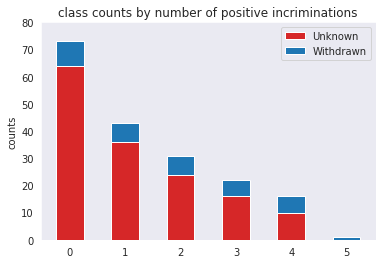

In [90]:
# Plot DILI class as a function of incriminating models. 

unk = counts_unk.tolist() + [0]
withd = count_with.tolist()


ind = np.arange(6)    # the x locations for the groups
width = 0.5       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, unk, width, color='#d62728')
p2 = plt.bar(ind, withd, width, bottom=unk)

plt.ylabel('counts')
plt.title('class counts by number of positive incriminations')

plt.xticks(ind, ('0', '1', '2', '3', '4', '5'))
plt.yticks(np.arange(0, 81, 10))
plt.legend((p1[0], p2[0]), ('Unknown', 'Withdrawn'))

plt.show()